In [1]:
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_path import path  # noqa
from pathlib import Path
from PIL import Image
import pytorch_lightning as pl
import torch

<a id="explore-the-data"></a>

### Explore the data

In [2]:
DATA_DIR = Path("data")
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

assert TRAIN_FEATURES.exists()

The training data consists of 11,748 "chips". Each chip is imagery of a specific area captured at a specific point in time. There are four images associated with each chip in the competition data. Each image within a chip captures light from a different range of wavelengths, or "band". For example, the B02 band for each chip shows the strengh of visible blue light, which has a wavelength around 492 nanometers (nm). The bands provided are:


<table border="1" class="table" style="width:70%; margin-left:auto; margin-right:auto">
  <thead>
    <tr style="text-align: right;">
      <th>Band</th>
      <th>Description</th>
      <th>Center wavelength</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>B02</td>
      <td>Blue visible light</td>
      <td>497 nm</td>
    </tr>
    <tr>
      <td>B03</td>
      <td>Green visible light</td>
      <td>560 nm</td>
    </tr>
    <tr>
      <td>B04</td>
      <td>Red visible light</td>
      <td>665 nm</td>
    </tr>
    <tr>
      <td>B08</td>
      <td>Near infrared light</td>
      <td>835 nm</td>
    </tr>
  </tbody>
</table>

In [3]:
BANDS = ["B02", "B03", "B04", "B08"]

#### Metadata

Let's start by looking at the metadata for the train and test sets, to understand what the images in this competition capture.

In [4]:
train_meta = pd.read_csv(DATA_DIR / "On_Cloud_N_Cloud_Cover_Detection_Challenge_-_train_metadata.csv.csv")
train_meta.head()

chip_id  location              datetime                   cloudpath
0    adwp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwp
1    adwu  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwu
2    adwz  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwz
3    adxp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adxp
4    aeaj  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/aeaj

In [5]:
# how many different chip ids, locations, and datetimes are there?
train_meta[["chip_id", "location", "datetime"]].nunique()

chip_id     11748
location       81
datetime       91
dtype: int64

In [6]:
train_location_counts = (
    train_meta.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

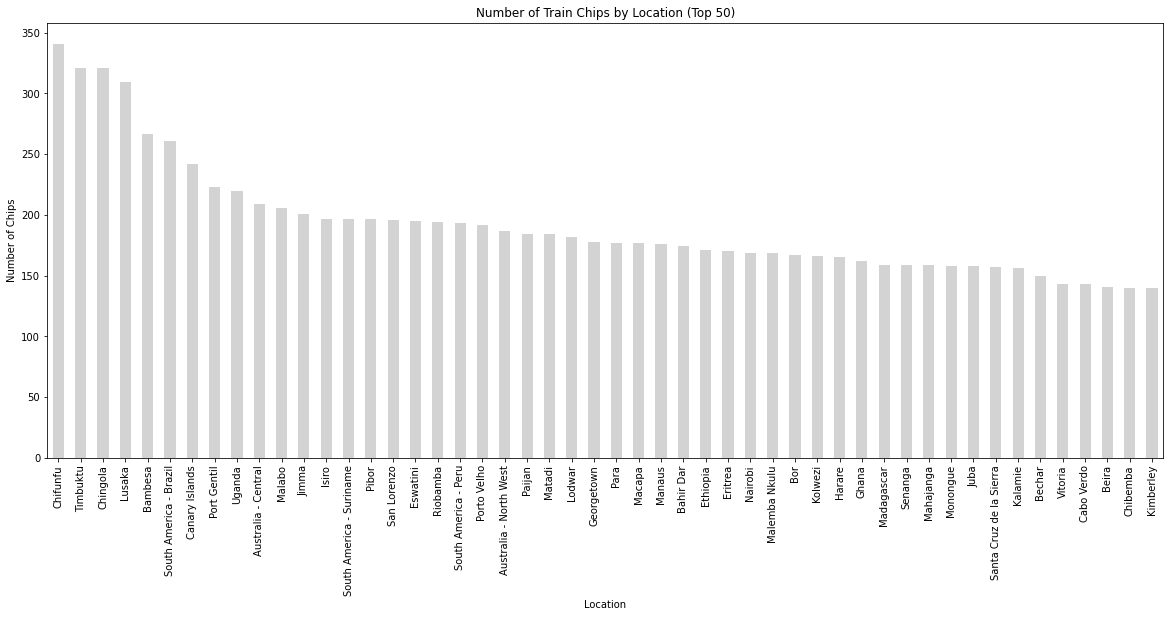

In [7]:
n = 50
plt.figure(figsize=(20, 8))
train_location_counts.head(n).plot(kind="bar", color="lightgray")
plt.xticks(rotation=90)
plt.xlabel("Location")
plt.ylabel("Number of Chips")
plt.title(f"Number of Train Chips by Location (Top {n})")
plt.show()

The train and test images are from all over the world! Location names can be countries (eg. Eswatini), cities (eg. Lusaka), or broader regions of a country (eg. Australia - Central). [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2/observation-scenario) flies over the part of the Earth between 56° South and 82.8° North, between Cape Horn and slightly north of Greenland, so our observations are all between these two latitudes. The chips are mostly in Africa and South America, with some in Australia too.

We also have a timestamp for each chip. What is the time range in the data?

In [8]:
train_meta["datetime"] = pd.to_datetime(train_meta["datetime"])
train_meta["year"] = train_meta.datetime.dt.year
train_meta["year-month"] = train_meta.datetime.dt.strftime('%B-%Y')

train_meta.groupby("year-month")[["chip_id"]].nunique().sort_index().rename(
    columns={"chip_id": "chip_count"}
)

chip_count
year-month                
April-2019             220
April-2020             995
August-2019              9
August-2020           1576
December-2019          159
February-2019          335
January-2020             6
July-2020              690
June-2020              555
March-2018              24
March-2020             334
May-2020               491
November-2018          143
November-2019          150
October-2018           159
September-2019         142
September-2020        5760

In [9]:
train_meta["datetime"].min(), train_meta["datetime"].max()

(Timestamp('2018-03-07 08:46:02+0000', tz='UTC'),
 Timestamp('2020-09-14 08:28:49+0000', tz='UTC'))

In [10]:
chips_per_locationtime = (
    train_meta.groupby(["location", "datetime"])[["chip_id"]]
    .nunique()
    .sort_values(by="chip_id", ascending=False)
    .rename(columns={"chip_id": "chip_count"})
)
chips_per_locationtime.head(10)

chip_count
location                 datetime                             
South America - Brazil   2020-09-06 15:02:37+00:00         261
Port Gentil              2020-09-08 09:50:58+00:00         223
Uganda                   2019-04-25 08:29:37+00:00         220
Australia - Central      2020-08-11 01:24:00+00:00         209
Malabo                   2020-09-06 10:00:03+00:00         206
Jimma                    2020-05-31 08:07:58+00:00         201
Chifunfu                 2020-04-29 08:20:47+00:00         197
South America - Suriname 2020-06-03 14:11:18+00:00         197
Isiro                    2020-08-28 08:39:29+00:00         197
Pibor                    2020-08-17 08:18:22+00:00         197

In [11]:
def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        # make sure a random sample of paths exist
        assert df.sample(n=40, random_state=5)[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        # make sure a random sample of paths exist
        assert df.sample(n=40, random_state=5)["label_path"].path.exists().all()

    return df


train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)
train_meta.head()

chip_id  location                  datetime                   cloudpath  \
0    adwp  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adwp   
1    adwu  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adwu   
2    adwz  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adwz   
3    adxp  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/adxp   
4    aeaj  Chifunfu 2020-04-29 08:20:47+00:00  az://./train_features/aeaj   

   year  year-month                          B02_path  \
0  2020  April-2020  data\train_features\adwp\B02.tif   
1  2020  April-2020  data\train_features\adwu\B02.tif   
2  2020  April-2020  data\train_features\adwz\B02.tif   
3  2020  April-2020  data\train_features\adxp\B02.tif   
4  2020  April-2020  data\train_features\aeaj\B02.tif   

                           B03_path                          B04_path  \
0  data\train_features\adwp\B03.tif  data\train_features\adwp\B04.tif   
1  data\train_features\adwu\B03.tif  data\train_features\adwu\B04.tif   
2  data\train_features\adwz\B03.tif  data\train_features\adwz\B04.tif   
3  data\train_features\adxp\B03.tif  data\train_features\adxp\B04.tif   
4  data\train_features\aeaj\B03.tif  data\train_features\aeaj\B04.tif   

                           B08_path                  label_path  
0  data\train_features\adwp\B08.tif  data\train_labels\adwp.tif  
1  data\train_features\adwu\B08.tif  data\train_labels\adwu.tif  
2  data\train_features\adwz\B08.tif  data\train_labels\adwz.tif  
3  data\train_features\adxp\B08.tif  data\train_labels\adxp.tif  
4  data\train_features\aeaj\B08.tif  data\train_labels\aeaj.tif

In [12]:
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11748 entries, 0 to 11747
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   chip_id     11748 non-null  object             
 1   location    11748 non-null  object             
 2   datetime    11748 non-null  datetime64[ns, UTC]
 3   cloudpath   11748 non-null  object             
 4   year        11748 non-null  int64              
 5   year-month  11748 non-null  object             
 6   B02_path    11748 non-null  object             
 7   B03_path    11748 non-null  object             
 8   B04_path    11748 non-null  object             
 9   B08_path    11748 non-null  object             
 10  label_path  11748 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(9)
memory usage: 1009.7+ KB


In [13]:
import rasterio

In [14]:
example_chip = train_meta[train_meta["chip_id"] == "pbyl"].iloc[0]
example_chip

chip_id                                   pbyl
location                                Lodwar
datetime             2020-09-08 08:09:15+00:00
cloudpath           az://./train_features/pbyl
year                                      2020
year-month                      September-2020
B02_path      data\train_features\pbyl\B02.tif
B03_path      data\train_features\pbyl\B03.tif
B04_path      data\train_features\pbyl\B04.tif
B08_path      data\train_features\pbyl\B08.tif
label_path          data\train_labels\pbyl.tif
Name: 6571, dtype: object

In [15]:
img = rasterio.open(example_chip["B04_path"])
chip_metadata = img.meta
img_array = img.read(1)

chip_metadata

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 771935.0,
        0.0, -10.0, 331300.0)}

We can see that the features are single-band images, with a shape of 512 x 512. The pixel values for each image measure the strength of light reflected back to the satellite for the specific set of wavelengths in that band. The array below shows the strength of red visible light, with wavelengts around 665 nm.

We can also see that there are no missing values in the image. This should be the case for all of the provided competition feature data.

In [16]:
# what does the image array look like?
print("Image array shape:", img_array.shape)
img_array

Image array shape: (512, 512)


array([[ 519,  532,  556, ..., 3662, 3564, 3544],
       [ 549,  539,  562, ..., 3604, 3520, 3518],
       [ 572,  524,  506, ..., 3514, 3488, 3518],
       ...,
       [1216, 2062, 2898, ..., 4050, 3610, 3328],
       [1632, 1932, 2588, ..., 4108, 3918, 3736],
       [1766, 2040, 2272, ..., 4152, 4028, 3824]], dtype=uint16)

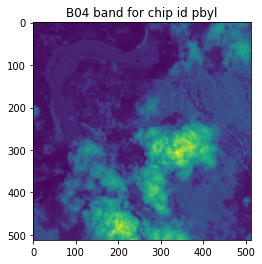

In [17]:
plt.imshow(img_array)
plt.title(f"B04 band for chip id {example_chip.chip_id}")
plt.show()

#### Coordinates

Using the metadata returned by `rasterio`, we can also get longitude and latitude coordinates.

In [18]:
# longitude/latitude of image's center
lon, lat = img.lnglat()
bounds = img.bounds
print(f"Longitude: {lon}, latitude: {lat}")

Longitude: 35.46935026347422, latitude: 2.9714117132510944


In [19]:
bounds

BoundingBox(left=771935.0, bottom=326180.0, right=777055.0, top=331300.0)

We have the longitude and latitude of the center of the image, but the bounding box values look very different. That's because the bounding box is given in whatever coordinate reference system the image is projected in, rather than traditional longitude and latiude. We can see which system with the `crs` value from the metadata.

We can convert the bounding box to longitude and latitude using `pyproj`.

In [20]:
import pyproj

In [21]:
def lat_long_bounds(filepath):
    """Given the path to a GeoTIFF, returns the image bounds in latitude and
    longitude coordinates.

    Returns points as a tuple of (left, bottom, right, top)
    """
    with rasterio.open(filepath) as im:
        bounds = im.bounds
        meta = im.meta
    # create a converter starting with the current projection
    current_crs = pyproj.CRS(meta["crs"])
    crs_transform = pyproj.Transformer.from_crs(current_crs, current_crs.geodetic_crs)

    # returns left, bottom, right, top
    return crs_transform.transform_bounds(*bounds)

In [22]:
left, bottom, right, top = lat_long_bounds(example_chip["B04_path"])
print(
    f"Image coordinates (lat, long):\nStart: ({left}, {bottom})"
    f"\nEnd: ({right}, {top})"
)

Image coordinates (lat, long):
Start: (2.948221298028172, 35.44628398518643)
End: (2.9946024439490517, 35.492417498478574)


In [23]:
current_crs = pyproj.CRS(img.meta["crs"])
current_crs

<Derived Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### True color image

We can make a composite image from the three visible bands (blue, green, and red) to visualize a high-quality, true color image. To show the true color image, we'll use the `rioxarray` and `xrspatial` packages designed for Sentinel-2 satellite data.

In [28]:
import rioxarray
import xrspatial.multispectral as ms

In [25]:
def true_color_img(chip_id, data_dir=TRAIN_FEATURES):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    chip_dir = data_dir / chip_id
    red = rioxarray.open_rasterio(chip_dir / "B04.tif").squeeze()
    green = rioxarray.open_rasterio(chip_dir / "B03.tif").squeeze()
    blue = rioxarray.open_rasterio(chip_dir / "B02.tif").squeeze()

    return ms.true_color(r=red, g=green, b=blue)

In [29]:
data_dir = TRAIN_FEATURES
chip_id = example_chip.chip_id
chip_dir = data_dir / chip_id
red = rioxarray.open_rasterio(chip_dir / "B04.tif").squeeze()
green = rioxarray.open_rasterio(chip_dir / "B03.tif").squeeze()
blue = rioxarray.open_rasterio(chip_dir / "B02.tif").squeeze()
red

<xarray.DataArray (y: 512, x: 512)>
[262144 values with dtype=uint16]
Coordinates:
    band         int32 1
  * x            (x) float64 7.719e+05 7.72e+05 7.72e+05 ... 7.77e+05 7.77e+05
  * y            (y) float64 3.313e+05 3.313e+05 ... 3.262e+05 3.262e+05
    spatial_ref  int32 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

Text(0.5, 1.0, 'True color image for chip id pbyl')

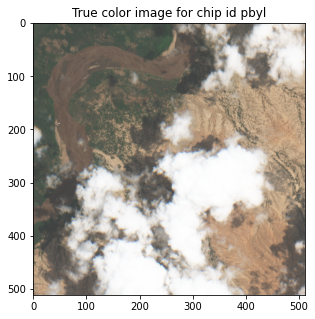

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
im = true_color_img(example_chip.chip_id)
ax.imshow(im)
plt.title(f"True color image for chip id {example_chip.chip_id}")

In [31]:
def display_random_chip(random_state):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    random_chip = train_meta.sample(random_state=random_state).iloc[0]

    ax[0].imshow(true_color_img(random_chip.chip_id))
    ax[0].set_title(f"Chip {random_chip.chip_id}\n(Location: {random_chip.location})")
    label_im = Image.open(random_chip.label_path)
    ax[1].imshow(label_im)
    ax[1].set_title(f"Chip {random_chip.chip_id} label")

    plt.tight_layout()
    plt.show()

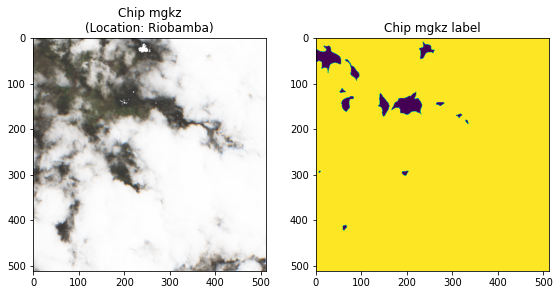

In [32]:
display_random_chip(1)

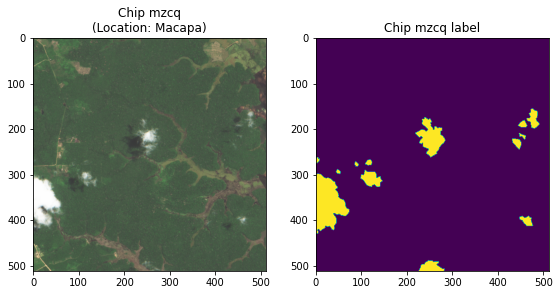

In [33]:
display_random_chip(9)

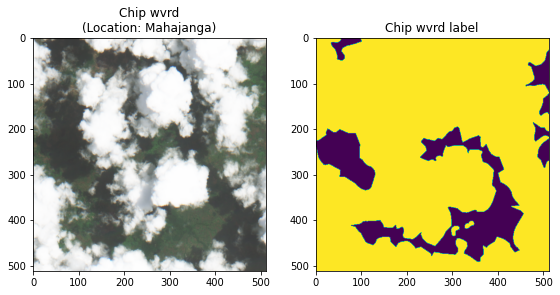

In [34]:
display_random_chip(40)